# Attention Visualization
## Extract attention weight from model

In [2]:
from utils.attentionvis import *

In [20]:
class CFG :
    # word2vec model path
    word2vec_path = './model/model_save/word2vec_0104.model' 
    # pre_trained model path , if given None, training from scratch
    state_dict_path = './model/model_save/PU-EPP_pretrained.pt'
    # Number CUDA Devices:
    gpu_number = torch.cuda.device_count()
    # DEVICE
    DEVICE = torch.device('cpu')

    # The last dimension of the protein data
    protein_dim = 100
    # The last dimension of the compound data
    atom_dim = 46
    # hidden dimension
    hid_dim = 128
    # norm_shape: layernorm parameter
    norm_shape = 128

In [21]:
model = get_model_vis(CFG)
# model = model.module

success load state dict
1


In [22]:
emb = get_feature_embedding(CFG)

In [23]:
# OTA
smiletest = 'C[C@@H]1CC2=C(C=C(C(=C2C(=O)O1)O)C(=O)N[C@@H](CC3=CC=CC=C3)C(=O)O)Cl'
# A0A5R9PF75
testseq ='MRTRLALAASLLAAVAPTASAATSGDAVLACGRLFDSRSGALLGPHTVVVRGGRIAEVVP\
GRSPDAAGAIDLSDRTCLPGFTDLHVHMGSQSSPQSYSEGFRLDPVDYAYRSVGYAEKTL\
SAGFTSVRDLGGEVALHLRDAINQGLVKGPRIFAAGKSIATTGGHADPTNGWNDALSHLV\
GPPGPTDGVVNSVDDARQAVRQRYKDGSDVIKITATGGVLSYAASGDAPQFTVDEVKAIV\
DTAKDYGYRVAAHAHGKEGMTRAILGGVTSIEHGTYMDEEVMRLMKARGTWYVPTIYAGR\
FVAEKAKIDGYFPDVVRPKAARIGALIQDTAGKAYRNGVKIAFGTDMGVGPHGDNAREFL\
YMVEAGIPAAQALQAATIRAAEVLGVDDQGVLAPGKRADIVALPGDPLADIGNVLKVDFV\
MKDGVVHREPAR'

In [24]:
model.eval()

with torch.no_grad():
    atom_feature, adj = emb.smiles_embedding(smiletest)
    protein = emb.sequence_embedding(testseq)
    tdata = data_collate(atom_feature.unsqueeze(0), adj.unsqueeze(0), protein.unsqueeze(0))
    compound,adjs,protein, compound_num,protein_num = tdata
    predicted_scores = model(protein, protein_num, compound,adjs, compound_num)
    attention_en = model.encoder.attention_weights
    attention_de = model.decoder.attention_weights

In [25]:
seq_attention = count_encoder_attetion(attention_en, [0,11], [0,7])
chem_attention = count_decoder_attetion(attention_de, 0, [0,11], [0,7])
inter_attention = count_decoder_attetion(attention_de, 1, [0,11], [0,7])

## Attention weight visualization (line chart)

In [26]:
import matplotlib.pyplot as plt

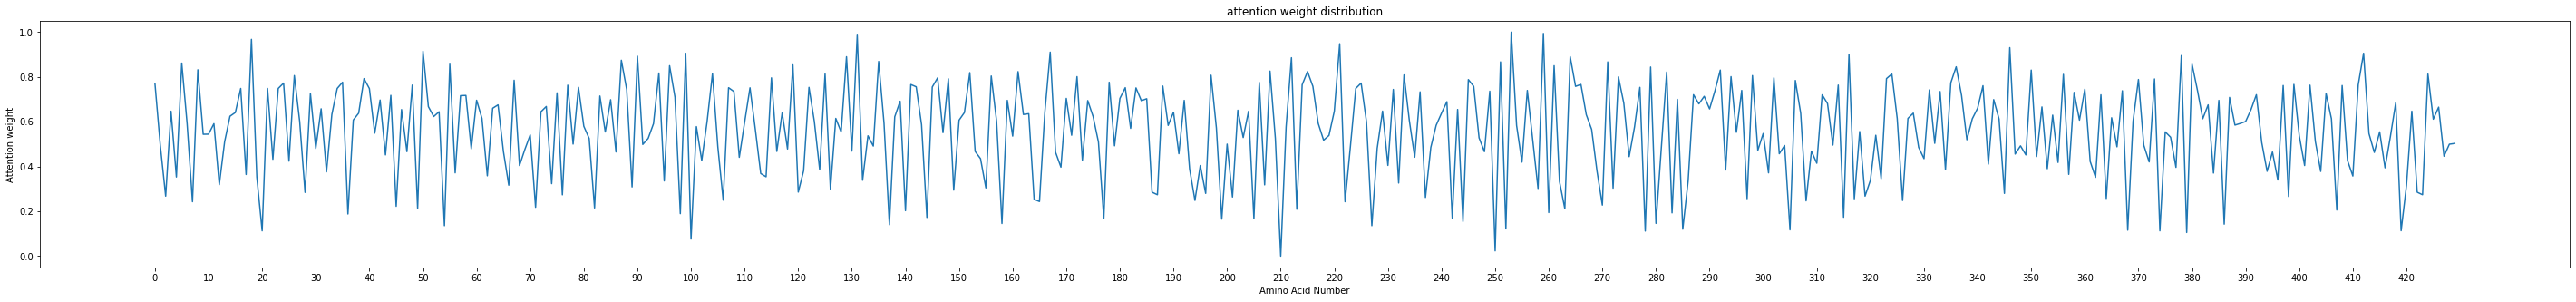

In [27]:
# interaction layer(for both enzymes and substrates)

att_draw = inter_attention

fig1 = plt.figure(figsize=(50, 5))
plt.plot(att_draw)
plt.xlabel("Amino Acid Number")
plt.ylabel("Attention weight")
plt.xticks( np.arange(0, len(att_draw), 10))
plt.title("attention weight distribution")

plt.show()

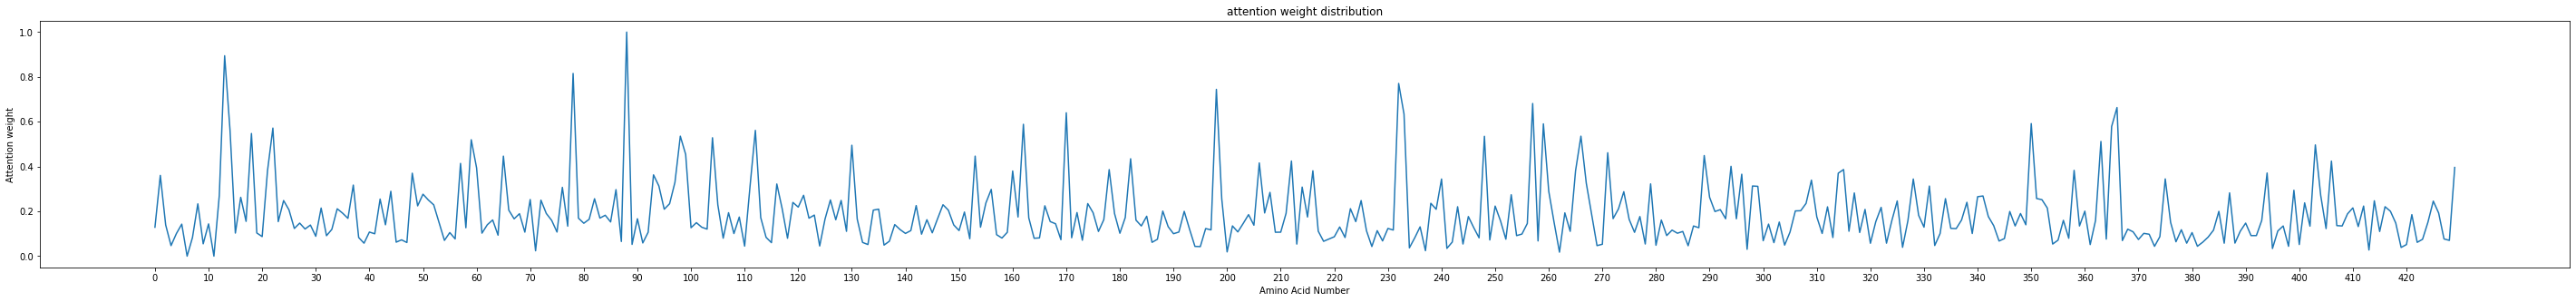

In [28]:
# encoding layer(for enzymes)

att_draw = seq_attention
fig1 = plt.figure(figsize=(50, 5))
plt.plot(att_draw)
plt.xlabel("Amino Acid Number")
plt.ylabel("Attention weight")
plt.xticks( np.arange(0, len(att_draw), 10))
plt.title("attention weight distribution")

plt.show()

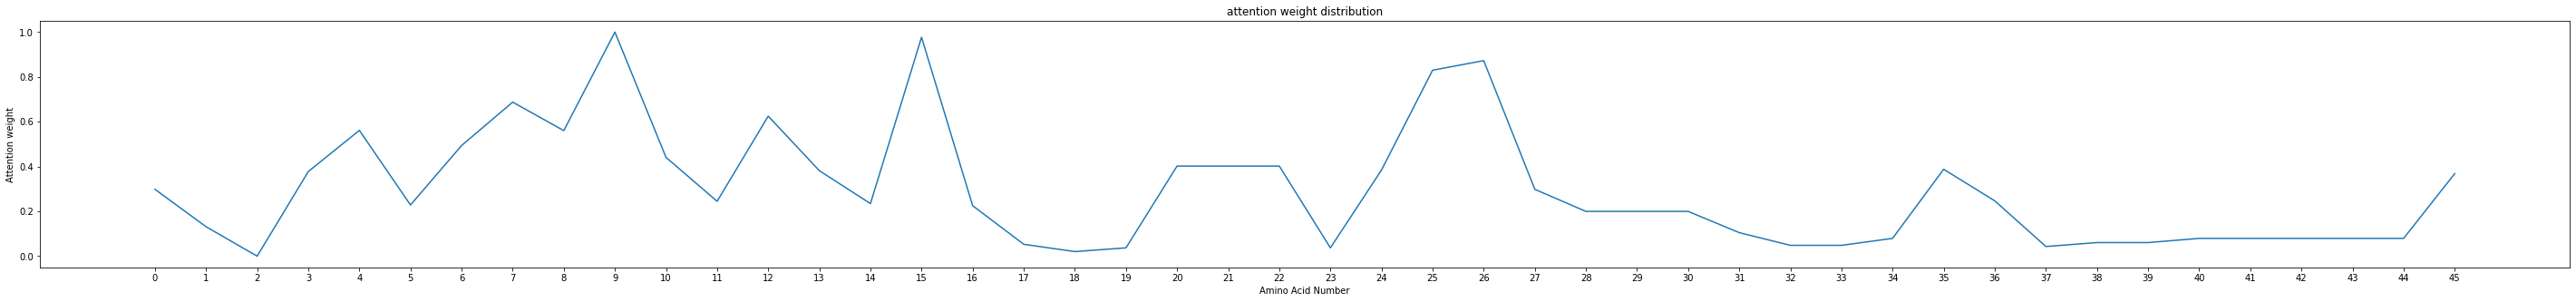

In [29]:
# decoding layer(for substrates)
att_draw = chem_attention
fig1 = plt.figure(figsize=(50, 5))
plt.plot(att_draw)
plt.xlabel("Amino Acid Number")
plt.ylabel("Attention weight")
plt.xticks( np.arange(0, len(att_draw), 1))
plt.title("attention weight distribution")

plt.show()

## Map attention weight of substrates to chemical structures

In [30]:
from rdkit.Chem import PyMol
from rdkit import Chem
import sys
from IPython.display import SVG
from rdkit import rdBase
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Draw import DrawMorganBit, DrawMorganBits,DrawMorganEnv, IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps as AttentionMaps

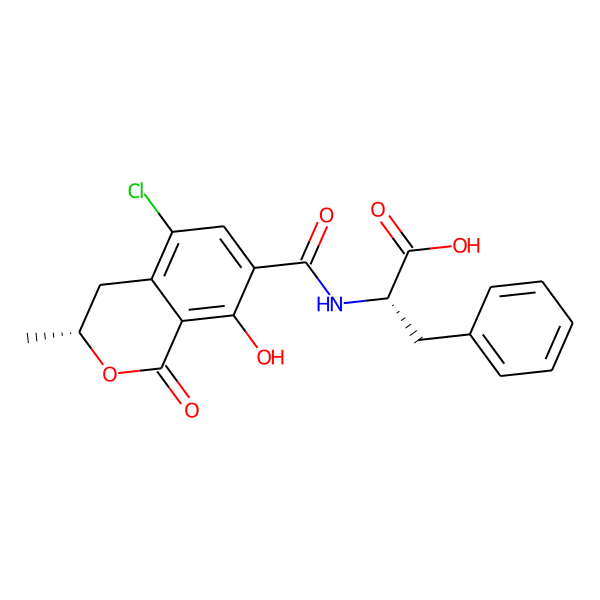

In [31]:
mol = Chem.MolFromSmiles(smiletest)
mol

In [32]:
# 原子序号标记
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol,atoms

In [33]:
IPythonConsole.molSize = 600,600

mol = Chem.AddHs(mol)
mol_idx,atoms = add_atom_index(mol)

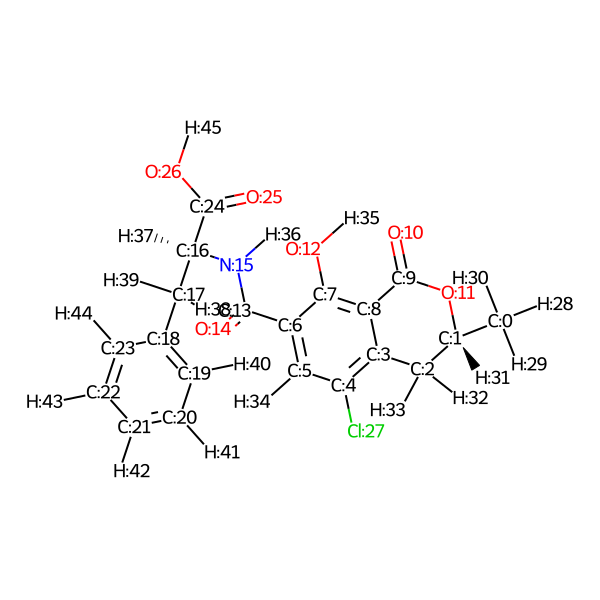

In [34]:
mol_idx

In [16]:
## Save as a picture file
# Draw.MolToImageFile(mol, 'ota_addHs.png', size=(600,600))

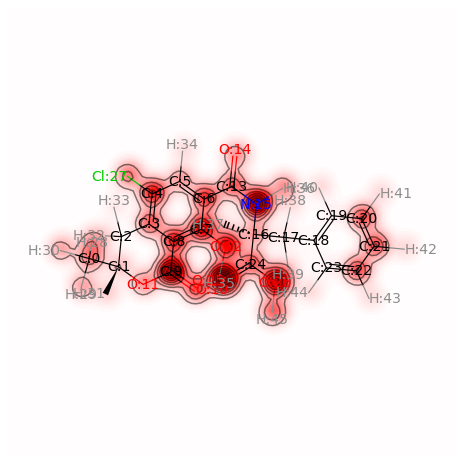

In [35]:
smiles_attention_list = list(chem_attention)

# Try more color themes
att_reds = AttentionMaps.GetSimilarityMapFromWeights(mol, smiles_attention_list, colorMap='seismic', contourLines=10)

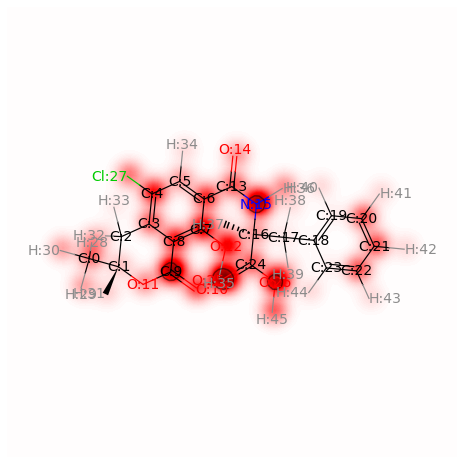

In [36]:
att_reds = AttentionMaps.GetSimilarityMapFromWeights(mol, smiles_attention_list, colorMap='seismic', contourLines=1,alpha=0.5)

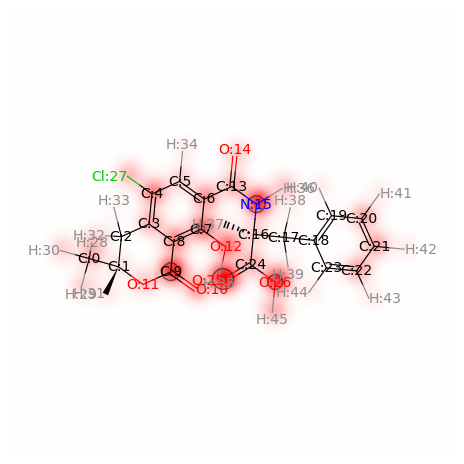

In [37]:
att_reds = AttentionMaps.GetSimilarityMapFromWeights(mol, smiles_attention_list, colorMap='bwr', contourLines=1)

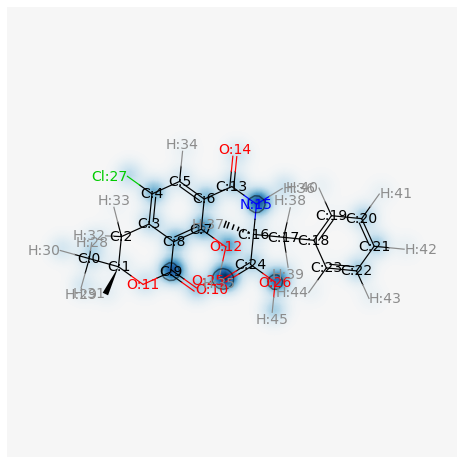

In [38]:
att_blue = AttentionMaps.GetSimilarityMapFromWeights(mol, smiles_attention_list, colorMap='RdBu', contourLines=1)

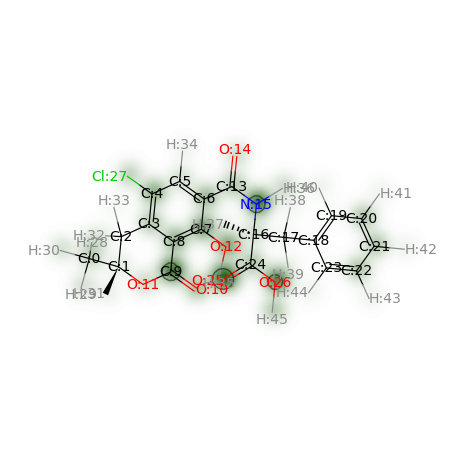

In [39]:
att_green = AttentionMaps.GetSimilarityMapFromWeights(mol, smiles_attention_list,contourLines=1)

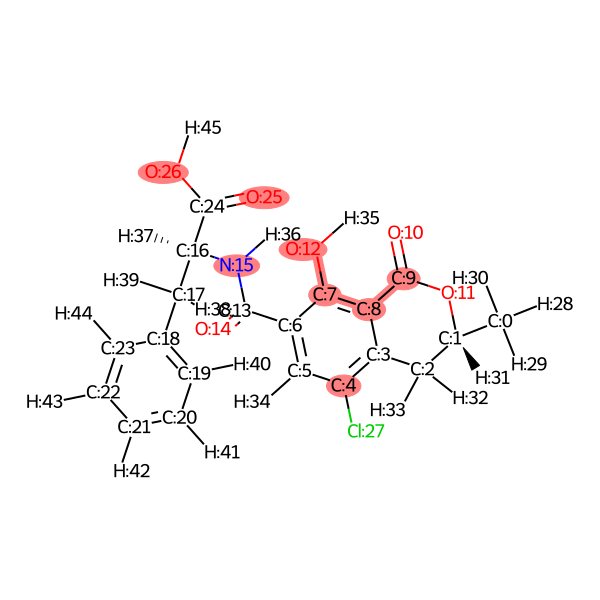

In [40]:
# Binarization
import pandas as pd

df = pd.DataFrame(chem_attention)
thres = 0.5
atom_index = list(df[df>=thres].dropna(axis=0,how='all').index)
mol.__sssAtoms = atom_index
mol

## Map attention weight of enzymes to protein structures

In [42]:
import pandas as pd

def seq2AA(seq_attention):
    # Map attention weights to each amino acid
    # pandas rolling function
    seq_attention = seq_attention.tolist()
    seq_attention.insert(0,0)
    seq_attention.insert(0,0)
    seq_attention.extend([0,0])
    seq_attention = pd.Series(seq_attention).rolling(window=3).max().dropna(axis=0,how='all').values
    return seq_attention

In [43]:
AA_attention = seq2AA(inter_attention)

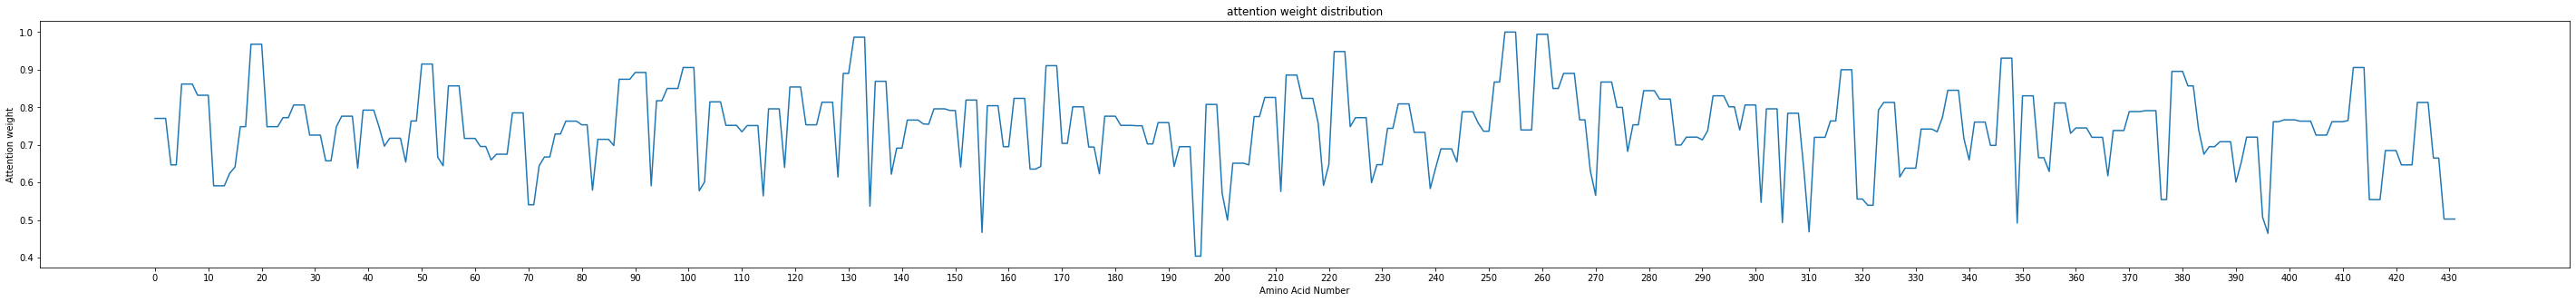

In [44]:
att_draw = AA_attention
fig1 = plt.figure(figsize=(50, 5))
plt.plot(att_draw)
plt.xlabel("Amino Acid Number")
plt.ylabel("Attention weight")
plt.xticks( np.arange(0, len(att_draw), 10))
plt.title("attention weight distribution")

plt.show()

In [45]:
# Map attention weights into the b-values of protein structure

In [46]:
from prody import *

In [47]:
# The protein structure is predicted by AlphaFold
atoms = parsePDB('./data/A0A5R9PF75.pdb')

@> 3182 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [48]:
att = pd.DataFrame(AA_attention,columns=['att'])

In [49]:
att

,att
0,0.770508
1,0.770508
2,0.770508
3,0.646973
4,0.646973
...,...
427,0.665039
428,0.665039
429,0.502930
430,0.502930


In [50]:
# The parts of protein structure prediction that are inaccurate are truncated
att = att[25:]

In [51]:
# Map attention weights to each atoms
atoms_att = []
for a in atoms:
    idx = a.getResindex()
    a_att = AA_attention[idx]
    atoms_att.append(a_att)

In [52]:
atoms.setBetas(atoms_att)

In [53]:
writePDB('./data/A0A5R9PF75_att.pdb', atoms)

'./data/A0A5R9PF75_att.pdb'

In [54]:
AA_attention.shape

(432,)

In [56]:
pd.DataFrame(AA_attention,columns=['att']).to_csv('A0A5R9PF75_att.csv')